In [1]:
!pip install river

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 6.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [2]:
from river import forest, tree, metrics, drift, stats
from river.utils.random import poisson
import matplotlib.pyplot as plt

class SmartARF(forest.ARFClassifier):
    def __init__(self, max_models=30, accuracy_drop_threshold=0.5, monitor_window=100, **kwargs):
        super().__init__(**kwargs)
        self.max_models = max_models
        self.accuracy_drop_threshold = accuracy_drop_threshold
        self.monitor_window = monitor_window
        self.model_count_history = []

        # For pruning
        self._accuracy_window = []          # List of recent accuracies for each tree
        self._warned_tree_ids = set()       # Trees under accuracy-drop observation
        self._warning_step = {}             # Step when warning was triggered
        self._warned_recent_acc = {}        # Accuracy at time of warning

    def learn_one(self, x, y):
        if len(self) == 0:
            self._init_ensemble(sorted(x.keys()))

        current_step = len(self.model_count_history)
        self.model_count_history.append(len(self.data))

        for i in range(len(self.data)):
            model = self.data[i]
            y_pred = model.predict_one(x)
            self._metrics[i].update(y_true=y, y_pred=y_pred)

            self._ensure_accuracy_window_exists(i)
            self._accuracy_window[i].append(int(y_pred == y))
            if len(self._accuracy_window[i]) > self.monitor_window:
                self._accuracy_window[i].pop(0)

            k = poisson(rate=self.lambda_value, rng=self._rng)
            if k > 0:
                model.learn_one(x=x, y=y, w=k)

                # Handle warning
                if not self._warning_detection_disabled:
                    self._warning_detectors[i].update(int(y_pred != y))
                    if self._warning_detectors[i].drift_detected:
                        self._background[i] = self._new_base_model()
                        self._warning_detectors[i] = self.warning_detector.clone()
                        self._warning_tracker[i] += 1

                        # Start tracking accuracy drop
                        self._warned_tree_ids.add(i)
                        self._warning_step[i] = current_step
                        self._warned_recent_acc[i] = self._get_recent_accuracy(i)

                # Handle drift
                if not self._drift_detection_disabled:
                    self._drift_detectors[i].update(int(y_pred != y))
                    if self._drift_detectors[i].drift_detected:
                        if self._background[i] is not None:
                            new_tree = self._background[i]

                            # Prune if at capacity
                            if len(self.data) >= self.max_models:
                                worst = self._find_worst_model()
                                self._remove_model(worst)

                            # Add new model
                            self.data.append(new_tree)
                            self._metrics.append(self.metric.clone())
                            self._drift_detectors.append(self.drift_detector.clone())
                            self._warning_detectors.append(self.warning_detector.clone())
                            self._background.append(None)
                            self._accuracy_window.append([])  # for new model
                            self._drift_tracker[i] += 1
                            self._background[i] = None

        self._check_prune_on_accuracy_drop(current_step)
        return self

    def _check_prune_on_accuracy_drop(self, current_step):
        to_remove = []
        for i in list(self._warned_tree_ids):
            age_since_warning = current_step - self._warning_step.get(i, 0)
            if age_since_warning > self.monitor_window:
                to_remove.append(i)
                continue

            current_acc = self._get_recent_accuracy(i)
            past_acc = self._warned_recent_acc.get(i, 1.0)

            if current_acc < self.accuracy_drop_threshold * past_acc:
                print(f"⚠️ Tree {i} accuracy drop: {past_acc:.2f} → {current_acc:.2f}. Pruning.")
                self._remove_model(i)
                to_remove.append(i)

        for i in to_remove:
            self._warned_tree_ids.discard(i)
            self._warning_step.pop(i, None)
            self._warned_recent_acc.pop(i, None)

    def _get_recent_accuracy(self, i):
        accs = self._accuracy_window[i]
        return sum(accs) / len(accs) if accs else 1.0

    def _ensure_accuracy_window_exists(self, i):
        while len(self._accuracy_window) <= i:
            self._accuracy_window.append([])

    def _find_worst_model(self):
        metric_scores = [m.get() for m in self._metrics]
        return metric_scores.index(min(metric_scores))

    def _remove_model(self, index):
        print(f"🪓 Removing tree {index} (score: {self._metrics[index].get():.4f})")
        del self.data[index]
        del self._metrics[index]
        del self._drift_detectors[index]
        del self._warning_detectors[index]
        del self._background[index]
        del self._accuracy_window[index]

        # Clean up pruning trackers
        self._warned_tree_ids = {i if i < index else i-1 for i in self._warned_tree_ids if i != index}
        self._warning_step = {i if i < index else i-1: v for i, v in self._warning_step.items() if i != index}
        self._warned_recent_acc = {i if i < index else i-1: v for i, v in self._warned_recent_acc.items() if i != index}


In [5]:
from river import datasets, preprocessing, metrics

# Stream with concept drift
dataset = datasets.synth.ConceptDriftStream(seed=420, position=500, width=60).take(10000)

# Model
model = SmartARF(
    n_models=10,
    max_models=14,
    warning_detector=drift.ADWIN(delta=0.05),
    seed=42,
    leaf_prediction="mc"
)

model = preprocessing.StandardScaler() | model
metric = metrics.Accuracy()

# Training loop
for x, y in dataset:
    y_pred = model.predict_one(x)
    model.learn_one(x, y)
    metric.update(y, y_pred)

print(f"\n✅ Final accuracy: {metric.get():.4f}")


🪓 Removing tree 13 (score: 0.5042)
🪓 Removing tree 13 (score: 0.5195)
🪓 Removing tree 11 (score: 0.5487)
🪓 Removing tree 13 (score: 0.4946)
🪓 Removing tree 12 (score: 0.5457)
🪓 Removing tree 13 (score: 0.4654)
🪓 Removing tree 12 (score: 0.5550)
🪓 Removing tree 13 (score: 0.5380)
🪓 Removing tree 13 (score: 0.5909)
🪓 Removing tree 13 (score: 0.5258)
🪓 Removing tree 6 (score: 0.6054)
🪓 Removing tree 13 (score: 0.5420)
🪓 Removing tree 13 (score: 0.6042)
🪓 Removing tree 13 (score: 0.5650)
🪓 Removing tree 0 (score: 0.6467)
🪓 Removing tree 12 (score: 0.5115)
🪓 Removing tree 12 (score: 0.5374)
🪓 Removing tree 13 (score: 0.5685)
🪓 Removing tree 13 (score: 0.5647)

✅ Final accuracy: 0.9456


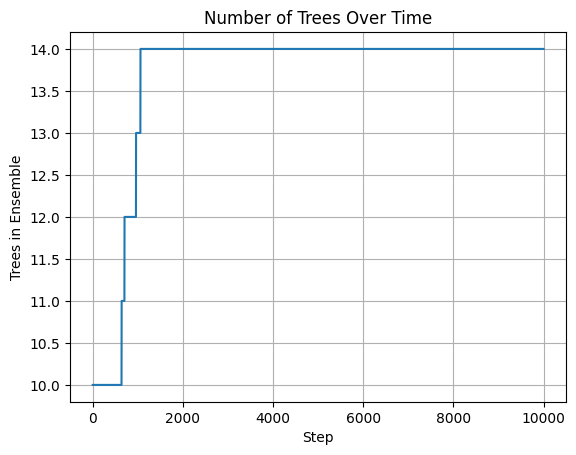

In [6]:
plt.plot(model[-1].model_count_history)
plt.title("Number of Trees Over Time")
plt.xlabel("Step")
plt.ylabel("Trees in Ensemble")
plt.grid(True)
plt.show()


In [7]:
from river import datasets, preprocessing, metrics

# Stream with concept drift
dataset = datasets.synth.ConceptDriftStream(seed=420, position=500, width=60).take(10000)

# Model
model = forest.ARFClassifier(
    n_models=15,
    warning_detector=drift.ADWIN(delta=0.01),
    seed=42,
    leaf_prediction="mc"
)

model = preprocessing.StandardScaler() | model
metric = metrics.Accuracy()

# Training loop
for x, y in dataset:
    y_pred = model.predict_one(x)
    model.learn_one(x, y)
    metric.update(y, y_pred)

print(f"\n✅ Final accuracy: {metric.get():.4f}")



✅ Final accuracy: 0.9080
